# Projective representation gradient descent test
Created 14/10/2024

Objectives:
* Adapt methods from "Unitary overlap gradient descent SPT extraction" notebook to learn unitaries which also form projective representations.

# Package imports

In [1]:
import sys
sys.path.append('../../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

In [4]:
from functools import reduce 

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [14]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [15]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [16]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [17]:
NUM_SITES = 6

In [18]:
e, a, b, c = symmetry_labels

In [19]:
group_products = [
    (a, a, e),
    (b, b, e),
    (c, c, e),
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

## Functions

In [20]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [21]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [22]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [23]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [24]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [25]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [26]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [27]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [28]:
def get_random_unitary_operator(mps_tensor, dim):
    # To-do: automate getting dimension
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)
    p_leg_conj = mps_tensor.get_leg(p_leg_label_conj)

    X = scipy.stats.unitary_group.rvs(dim)

    out = npc.Array.from_ndarray(
        X,
        legcharges=[p_leg, p_leg_conj],
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [29]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

### Gradients

In [109]:
def unitarity_gradient(matrix, grouped_physical_leg_label='p',
                      grouped_physical_leg_conj_label='p*'):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())

    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    return (t - matrix, score_2, score_4)

In [31]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [32]:
def update(matrix, reduced_density_matrix, unitarity_scores, overlap_scores,
           target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, target=1):

    u_grad, u_score_2, u_score_4 = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    u_score = u_score_4 - 2*u_score_2 + matrix_dim
    unitarity_scores.append(u_score.real)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(overlap)

    target_score = (
        (overlap_lr/2.0)*(target - np.abs(overlap))**2 +
        (unitarity_lr/4.0)*u_score.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    matrix -= gradient

### Proj rep functions

In [33]:
IDENTITY_LABEL = 'II'

In [34]:
def update_grad_dict(grad_dict, group_element_label, value):
    if group_element_label in grad_dict:
        grad_dict[group_element_label] += value
    else:
        grad_dict[group_element_label] = value

In [35]:
def get_unitary_from_dict(unitary_dict, label, identity_label=IDENTITY_LABEL):
    if label == identity_label:
        return None
    else:
        return unitary_dict[label]

In [122]:
def update_grad_inverse_pair_case(unitary_1, unitary_2, group_label_1,
                               group_label_2, matrix_mul, grad_dict,
                               scores_dict, identity_label=IDENTITY_LABEL):
    u1, u2 = unitary_1, unitary_2
    
    u3 = matrix_mul(u1, u2)

    leg_labels = u3.get_leg_labels()

    c = npc.trace(u3, *leg_labels)
    c_normed = c/(np.abs(c))

    o1 = matrix_mul(u3, u2.conj())
    o2 = matrix_mul(u1.conj(), u3)

    grad_1 = o1 - c_normed*(u2.conj())
    grad_2 = o2 - c_normed*(u1.conj())

    update_grad_dict(grad_dict, group_label_1, grad_1)
    update_grad_dict(grad_dict, group_label_2, grad_2)

    s1 = npc.tensordot(o1, u1.conj(), [leg_labels, leg_labels[::-1]])
    s2 = np.abs(c)
    s3 = u3.shape[0]
    
    score = (s1 -2*s2 + s3).real

    scores_dict[(group_label_1, group_label_2, identity_label)] = score

In [192]:
def update_grad_generic_case(unitary_triple, group_label_triple, matrix_mul,
                          grad_dict, scores_dict):
    
    u_a, u_b, u_c = unitary_triple

    # Perform matrix multiplications in a way that's difficult to read but
    # ultimately reduces the number of matrix multiplications performed.
    u1 = matrix_mul(u_a, u_b)
    u2 = matrix_mul(u_a.conj(), u_c)
    u3 = matrix_mul(u_c, u_b.conj())

    u_triple = matrix_mul(u1, u_c.conj())
    u4 = matrix_mul(u_triple, u3)
    u5 = matrix_mul(u_a.conj(), u1)
    u6 = reduce(matrix_mul, [u5, u_c.conj(), u_c])
    u7 = matrix_mul(u3, u5)

    leg_labels = u_triple.get_leg_labels()

    c = npc.trace(u_triple, *leg_labels)
    c_normed = c/(np.abs(c))

    grads = [
        u4 - c_normed*u3,
        u6 - c_normed*u2,
        u7 - c_normed.conjugate()*u1
    ]

    for l, g in zip(group_label_triple, grads):
        update_grad_dict(grad_dict, l, g)
    
    s1 = npc.tensordot(u4, u_a.conj(), [leg_labels, leg_labels[::-1]])
    s2 = np.abs(c)
    s3 = u_triple.shape[0]
    
    score = (s1 -2*s2 + s3).real

    scores_dict[group_label_triple] = score

In [38]:
def update_grad(unitary_dict, group_label_triple, matrix_mul, grad_dict,
                scores_dict, identity_label=IDENTITY_LABEL):
    u_a, u_b, u_c = [
        get_unitary_from_dict(unitary_dict, g)
        for g in group_label_triple
    ]

    if u_c is None:
        update_grad_inverse_pair_case(
            u_a,
            u_b,
            group_label_triple[0],
            group_label_triple[1],
            matrix_mul,
            grad_dict,
            scores_dict,
            identity_label
        )
    else:
        update_grad_generic_case(
            (u_a, u_b, u_c),
            group_label_triple,
            matrix_mul,
            grad_dict,
            scores_dict
        )

In [39]:
# Unused functions
def get_grad_first_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_c, u_b.conj())

    u_2 = reduce(matrix_mul, [u_a, u_b, u_c.conj(), u_1])

    return u1 - trace_phase*u_2

def get_grad_second_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_a.conj(), u_c)

    u_2 = reduce(matrix_mul, [u_a.conj(), u_a, u_b, u_c.conj(), u_c])

    return u1 - trace_phase*u_2

def get_grad_third_element(u_a, u_b, u_c, trace_phase, matrix_mul):
    u_1 = matrix_mul(u_a, u_b)

    u_2 = reduce(matrix_mul, [u_c, u_b.conj(), u_a.conj(), u_1])

    return u1 - trace_phase.conjugate()*u_2

grad_element_functions = [
    get_grad_first_element,
    get_grad_second_element,
    get_grad_third_element
]

In [40]:
def get_proj_rep_grad(unitary_dict, group_label_triples, physical_leg_label,
             physical_leg_conj_label, identity_label=IDENTITY_LABEL):
    
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [[physical_leg_label,], [physical_leg_conj_label,]]
        )

    grad_dict = dict()
    scores_dict = dict()

    for group_label_triple in group_label_triples:
        update_grad(
            unitary_dict,
            group_label_triple,
            matrix_multiplication,
            grad_dict,
            scores_dict,
            identity_label=IDENTITY_LABEL
        )

    score = sum(scores_dict.values())

    return grad_dict, score

In [41]:
def get_reduced_density_matrix(symmetry_case, num_sites=NUM_SITES, normalise=False):
    mps_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    rdm = symmetry_case.right_projected_symmetry_state

    if normalise:
        normalisation = npc.trace(rdm, 'vR', 'vR*')
        norm_phase = normalisation/np.abs(normalisation)
    
        rdm *= norm_phase.conj()

    for i, b in enumerate(mps_tensors):
        b_current = b.replace_label('p', f'p{i}')
    
        rdm = npc.tensordot(rdm, b_current, [['vR'], ['vL']])
        rdm = npc.tensordot(rdm, b_current.conj(), [['vR*'], ['vL*']])
    
    rdm = npc.trace(rdm, 'vR', 'vR*')

    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    rdm = rdm.combine_legs([leg_labels, leg_conj_labels])

    return rdm

In [42]:
def get_grouped_leg_labels(num_sites):
    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
    grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

    return (grouped_physical_leg_label, grouped_physical_leg_conj_label)

In [43]:
def multiply_tenpy_matrices(m1, m2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    return npc.tensordot(
        m1,
        m2,
        [
            [grouped_physical_leg_label,],
            [grouped_physical_leg_conj_label,]
        ]
    )

In [44]:
def get_overlap_target(symmetry_case):
    singular_val = symmetry_case.symmetry_transfer_matrix_singular_vals[0]
    target = np.power(singular_val, -1/2)

    return target

In [45]:
def initalize_optimization(symmetry_cases, num_sites,
                           random_initialisation=False):

    # Don't forget to only pass in symmetry_cases without identity!
    # Should maybe allow for identity as well...?

    reduced_density_matrices = {
        l: get_reduced_density_matrix(c, num_sites)
        for l, c in zip(symmetry_labels[1:], symmetry_cases)
    }

    overlap_targets = {
        l: get_overlap_target(c)
        for l, c in zip(symmetry_labels[1:], symmetry_cases)
    }

    leg_label, leg_conj_label = get_grouped_leg_labels(num_sites)

    # Assuming spin 1/2
    matrix_dim = 2**num_sites

    if random_initialisation:
        solutions_dict = {
            l: get_random_unitary_operator(rdm, matrix_dim)
            for l, rdm in reduced_density_matrices.items()
        }
    else:
        solutions_dict = {
            l: get_identity_operator(rdm)
            for l, rdm in reduced_density_matrices.items()
        }

    unitarity_scores = {l:list() for l in symmetry_labels[1:]}
    overall_unitarity_scores = list()
    overlap_scores = {l:list() for l in symmetry_labels[1:]}
    overall_target_overlap_scores = list()
    proj_rep_scores = list()
    # Be clearer with names?
    cost_function_scores = list()

    # Implement checks...?

    return (
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
    )

In [46]:
def get_unitarity_gradients(solutions_dict, matrix_dim, leg_label,
                            leg_conj_label):
    grad_score_triples = {
        l: unitarity_gradient(v, leg_label, leg_conj_label)
        for l, v in solutions_dict.items()
    }

    grads = {l: t[0] for l, t in grad_score_triples.items()}

    get_u_score = lambda t: (t[2] - 2*t[1] + matrix_dim).real

    scores = {l: get_u_score(t) for l, t in grad_score_triples.items()}

    return grads, scores

In [47]:
def get_overlap_gradients(solutions_dict, reduced_density_matrices,
                          overlap_targets, leg_label, leg_conj_label):
    grads = dict()
    scores = dict()

    for label, sol in solutions_dict.items():
        rdm = reduced_density_matrices[label]
        overlap_target = overlap_targets[label]

        gradient, overlap_score = overlap_gradient(
            sol,
            rdm,
            leg_label,
            leg_conj_label,
            target=overlap_target
        )

        grads[label] = gradient
        scores[label] = overlap_score

    return grads, scores

In [48]:
def update_once(reduced_density_matrices, overlap_targets, leg_label,
                leg_conj_label, matrix_dim, solutions_dict, unitarity_scores,
                overall_unitarity_scores, overlaps,
                overall_target_overlap_scores, proj_rep_scores,
                cost_function_scores, group_label_triples, unitarity_lr,
                overlap_lr, proj_rep_lr):


    unitarity_grads, current_u_scores = get_unitarity_gradients(
        solutions_dict, matrix_dim,leg_label, leg_conj_label
    )

    for l, s in current_u_scores.items():
        unitarity_scores[l].append(s)

    current_u_score = sum(current_u_scores.values())
    overall_unitarity_scores.append(current_u_score)

    overlap_grads, current_overlaps = get_overlap_gradients(
        solutions_dict,
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label
    )

    for l, s in current_overlaps.items():
        overlaps[l].append(np.abs(s))

    overlap_target_score = sum(
        (overlap_targets[l] - np.abs(current_overlaps[l]))**2
        for l in current_overlaps
    )

    overall_target_overlap_scores.append(overlap_target_score)

    # Proj rep case
    proj_rep_grads, proj_rep_score = get_proj_rep_grad(
        solutions_dict,
        group_label_triples,
        leg_label,
        leg_conj_label,
        identity_label=IDENTITY_LABEL
    )

    proj_rep_scores.append(proj_rep_score)

    cost_function_score = (
        (overlap_lr/2.0)*overlap_target_score +
        (unitarity_lr/4.0)*current_u_score +
        (proj_rep_lr)*proj_rep_score
    )
        
    cost_function_scores.append(cost_function_score)

    # Update each unitary
    for l in solutions_dict:
        solutions_dict[l] -= unitarity_lr*unitarity_grads[l]
        solutions_dict[l] -= overlap_lr*overlap_grads[l]
        solutions_dict[l] -= proj_rep_lr*proj_rep_grads[l]

In [49]:
def repeat_update(reduced_density_matrices, overlap_targets, leg_label,
                leg_conj_label, matrix_dim, solutions_dict, unitarity_scores,
                overall_unitarity_scores, overlaps,
                overall_target_overlap_scores, proj_rep_scores,
                cost_function_scores, group_label_triples, unitarity_lr,
                overlap_lr, proj_rep_lr, num_iterations):

    for _ in range(num_iterations):
        update_once(
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlaps,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores,
            group_label_triples,
            unitarity_lr,
            overlap_lr,
            proj_rep_lr
        )

# Test

In [347]:
test_cases = cases[0]

In [348]:
test_cases

## Run 1

In [349]:
initial_params = initalize_optimization(
    test_cases[1:], 4, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [350]:
lr = 0.05

In [351]:
unitarity_lr = lr
overlap_lr = lr
proj_rep_lr = lr

In [352]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    300
)

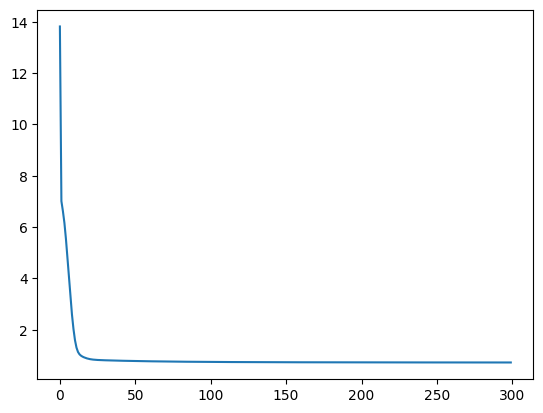

In [353]:
plt.plot(cost_function_scores)

In [354]:
cost_function_scores[-1]

0.7281069975003284

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/111217294.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


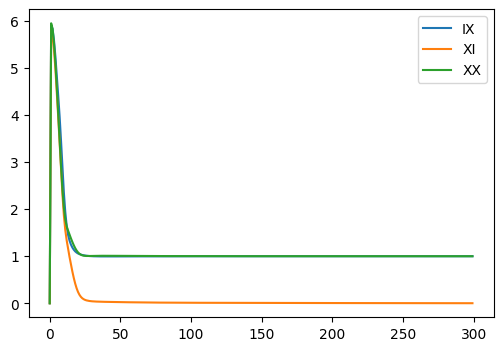

In [355]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in unitarity_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/18745376.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


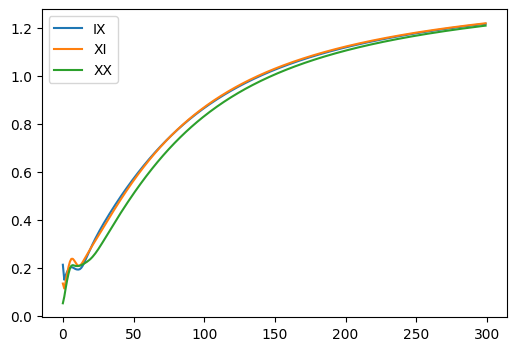

In [356]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in overlap_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

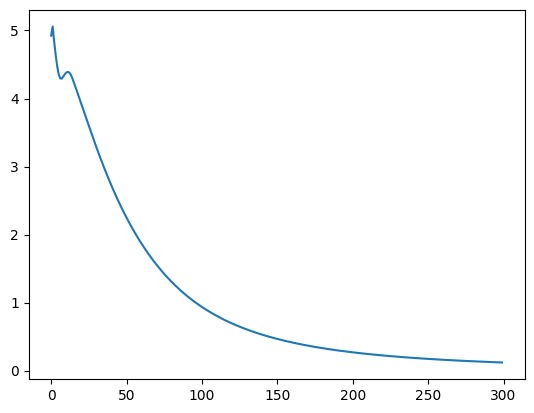

In [357]:
plt.plot(overall_target_overlap_scores)

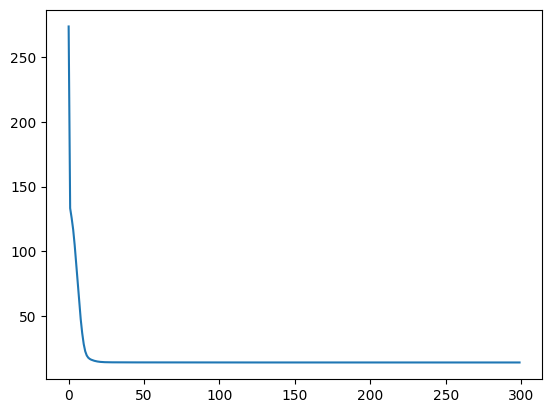

In [358]:
plt.plot(proj_rep_scores)

In [359]:
proj_rep_scores[-1]

14.002005687781606

## Run 2

In [361]:
initial_params = initalize_optimization(
    test_cases[1:], 4, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [362]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [363]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    1000
)

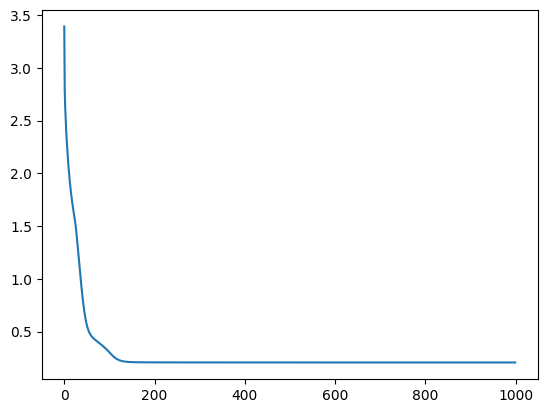

In [364]:
plt.plot(cost_function_scores)

In [365]:
cost_function_scores[-1]

0.2064936323816783

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/111217294.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


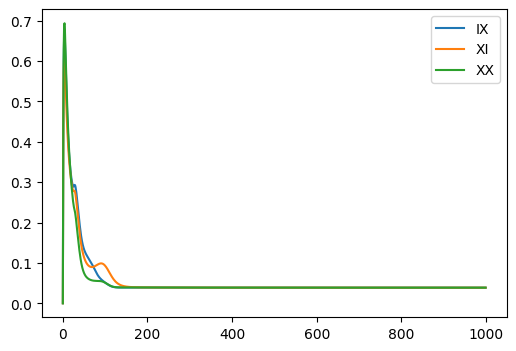

In [366]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in unitarity_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

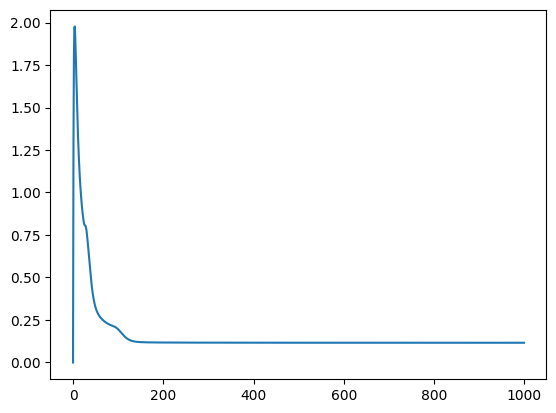

In [367]:
plt.plot(overall_unitarity_scores)

In [368]:
[l[-1] for l in unitarity_scores.values()]

[0.038658114448743675, 0.03866641166405316, 0.038666216840722356]

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/18745376.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


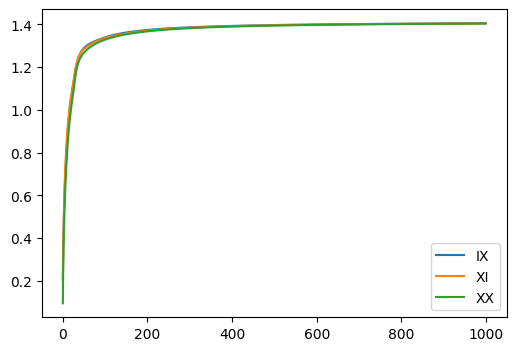

In [369]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in overlap_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

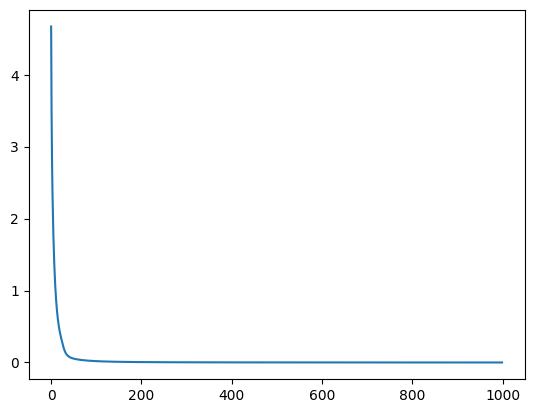

In [370]:
plt.plot(overall_target_overlap_scores)

In [371]:
overall_target_overlap_scores[-1]

0.0002517723210009427

In [372]:
[l[-1] for l in overlap_scores.values()]

[1.4055456819157979, 1.405194584490514, 1.4044514823010827]

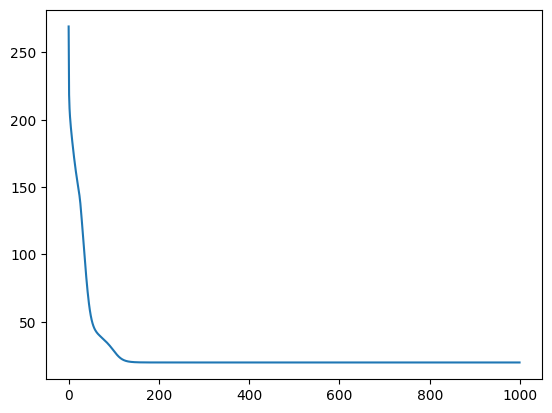

In [373]:
plt.plot(proj_rep_scores)

In [374]:
proj_rep_scores[-1]

19.775656081201422

## Run 3

In [376]:
initial_params = initalize_optimization(
    test_cases[1:], 4, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [377]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [378]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    1000
)

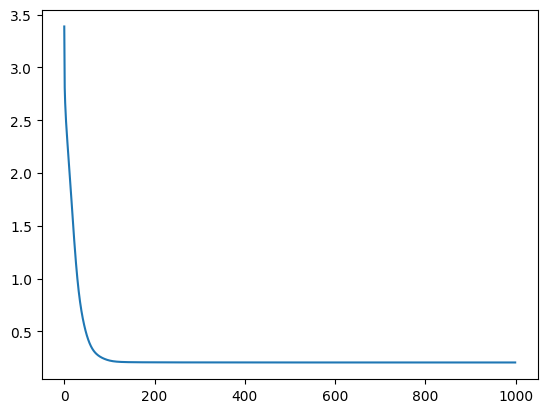

In [379]:
plt.plot(cost_function_scores)

In [380]:
cost_function_scores[-1]

0.20649703021995264

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/111217294.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


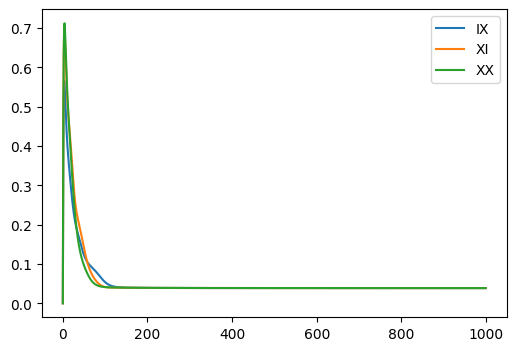

In [381]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in unitarity_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

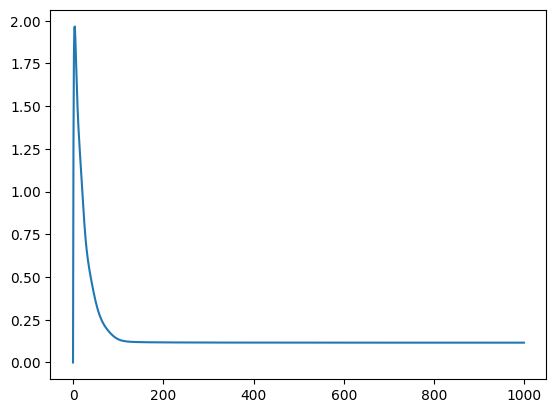

In [382]:
plt.plot(overall_unitarity_scores)

In [383]:
[l[-1] for l in unitarity_scores.values()]

[0.03866102080690581, 0.03866180661869478, 0.038664533403061085]

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/18745376.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


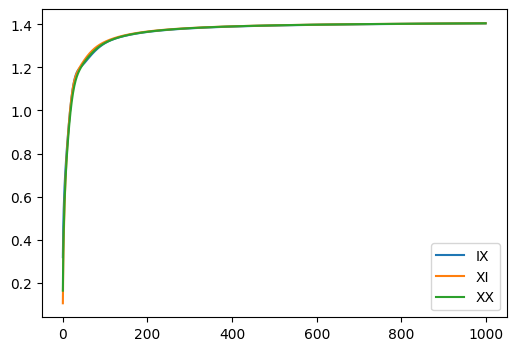

In [384]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in overlap_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

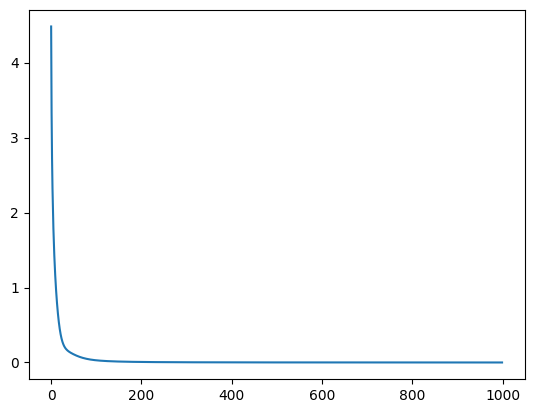

In [385]:
plt.plot(overall_target_overlap_scores)

In [386]:
overall_target_overlap_scores[-1]

0.00026718564801091513

In [387]:
[l[-1] for l in overlap_scores.values()]

[1.404494244544007, 1.404931913212968, 1.4049091818017558]

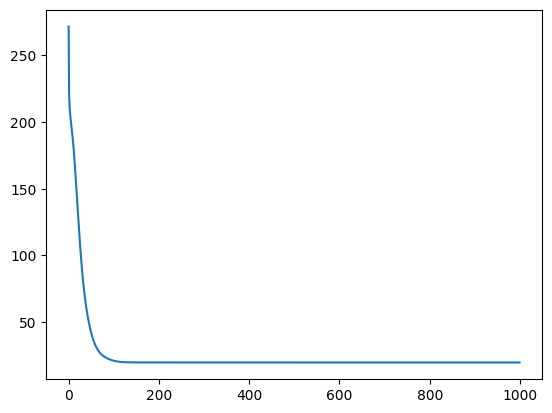

In [388]:
plt.plot(proj_rep_scores)

In [389]:
proj_rep_scores[-1]

19.775790031060136

# Debugging
Still not working, so simplify.

In [90]:
help(multiply_tenpy_matrices)

Help on function multiply_tenpy_matrices in module __main__:

multiply_tenpy_matrices(m1, m2, grouped_physical_leg_label='p', grouped_physical_leg_conj_label='p*')



In [91]:
def simple_proj_rep_gradient(u_a, u_b, u_c):
    grad_a_1 = reduce(multiply_tenpy_matrices, [u_a, u_b, u_c.conj(), u_c, u_b.conj()])
    grad_b_1 = reduce(multiply_tenpy_matrices, [u_a.conj(), u_a, u_b, u_c.conj(), u_c])
    grad_c_1 = reduce(multiply_tenpy_matrices, [u_c, u_b.conj(), u_a.conj(), u_a, u_b])

    m = reduce(multiply_tenpy_matrices, [u_a, u_b, u_c.conj()])
    c = npc.trace(m)
    c_normed = c/np.abs(c)

    m2 = multiply_tenpy_matrices(grad_a_1, u_a.conj())
    c2 = npc.trace(m2)

    grad_a_2 = multiply_tenpy_matrices(u_c, u_b.conj())
    grad_b_2 = multiply_tenpy_matrices(u_a.conj(), u_c)
    grad_c_2 = multiply_tenpy_matrices(u_a, u_b)

    c3 = u_a.shape[0]
    
    score = c2 - 2.0*np.abs(c) + c3

    grads = (
        grad_a_1 - c_normed*grad_a_2,
        grad_b_1 - c_normed*grad_b_2,
        grad_c_1 - (c_normed.conj())*grad_c_2
    )

    return (grads, score)

## Just proj rep

In [92]:
rdm = get_reduced_density_matrix(cases[0][2], 3, True)
rdm.ireplace_labels(['(p0.p1.p2)', '(p0*.p1*.p2*)'], ['p','p*'])

<npc.Array shape=(8, 8) labels=['p', 'p*']>

In [93]:
matrix_dim = 2**3

In [94]:
u_a, u_b, u_c = (
    get_random_unitary_operator(rdm, matrix_dim),
    get_random_unitary_operator(rdm, matrix_dim),
    get_random_unitary_operator(rdm, matrix_dim)
)

In [95]:
simple_proj_rep_gradient(u_a, u_b, u_c)

((<npc.Array shape=(8, 8) labels=['p*', 'p']>,
  <npc.Array shape=(8, 8) labels=['p*', 'p']>,
  <npc.Array shape=(8, 8) labels=['p*', 'p']>),
 (13.369810615264527+5.467401989760317e-17j))

In [96]:
scores = list()

In [97]:
lr = 0.01

In [98]:
for _ in range(1000):
    ((g_a, g_b, g_c), s) = simple_proj_rep_gradient(u_a, u_b, u_c) 

    scores.append(s)
    u_a -= lr*g_a
    u_b -= lr*g_b
    u_c -= lr*g_c

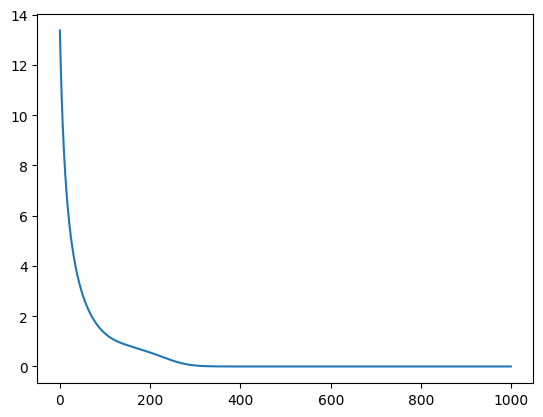

In [99]:
plt.plot(scores)

In [100]:
scores[-1]

(2.6645352591003757e-15-6.253500824356992e-16j)

It's working. Now add unitarity gradients and see what happens.

Shouldn't be much serious though.

## Proj rep and unitarity

In [101]:
u_a, u_b, u_c = (
    get_random_unitary_operator(rdm, matrix_dim),
    get_random_unitary_operator(rdm, matrix_dim),
    get_random_unitary_operator(rdm, matrix_dim)
)

In [102]:
simple_proj_rep_gradient(u_a, u_b, u_c)

((<npc.Array shape=(8, 8) labels=['p*', 'p']>,
  <npc.Array shape=(8, 8) labels=['p*', 'p']>,
  <npc.Array shape=(8, 8) labels=['p*', 'p']>),
 (15.805222767468624+2.275407155224749e-17j))

In [103]:
proj_rep_scores = list()
unitarity_scores = list()
scores = list()

In [114]:
unitarity_gradient(u_a)

(<npc.Array shape=(8, 8) labels=['p*', 'p']>,
 (7.999999999999997+1.5216286789718898e-17j),
 (7.999999999999995+2.220446049250313e-16j))

In [97]:
lr = 0.01

In [115]:
for _ in range(1000):
    ((pr_g_a, pr_g_b, pr_g_c), pr_s) = simple_proj_rep_gradient(u_a, u_b, u_c)
    
    (u_g_a, u_s_a_2, u_s_a_4) = unitarity_gradient(u_a)
    (u_g_b, u_s_b_2, u_s_b_4) = unitarity_gradient(u_b)
    (u_g_c, u_s_c_2, u_s_c_4) = unitarity_gradient(u_c)

    proj_rep_scores.append(pr_s)

    u_score = sum([
        u_s_a_4,
        -2*u_s_a_2,
        u_s_b_4,
        -2*u_s_b_2,
        u_s_c_4,
        -2*u_s_c_2,
        3*matrix_dim
    ])

    unitarity_scores.append(u_score)

    scores.append(lr*(pr_s + u_score/4.0))

    g_a = pr_g_a + u_g_a
    g_b = pr_g_b + u_g_b
    g_c = pr_g_c + u_g_c
    
    u_a -= lr*g_a
    u_b -= lr*g_b
    u_c -= lr*g_c

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


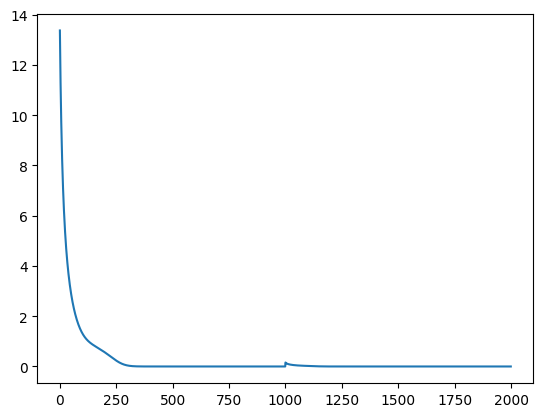

In [116]:
plt.plot(scores)

In [117]:
scores[-1]

-9.965067612894984e-19j

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


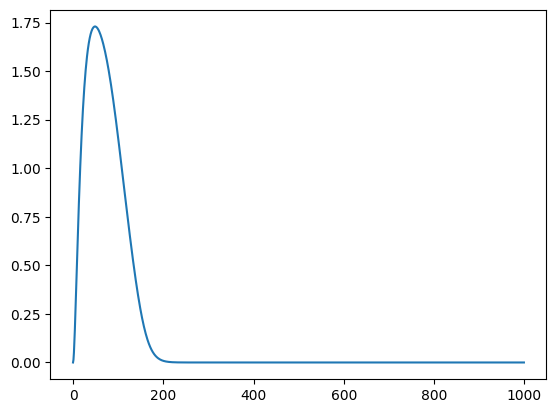

In [118]:
plt.plot(unitarity_scores)

In [120]:
unitarity_scores[-1]

1.42239305879938e-16j

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


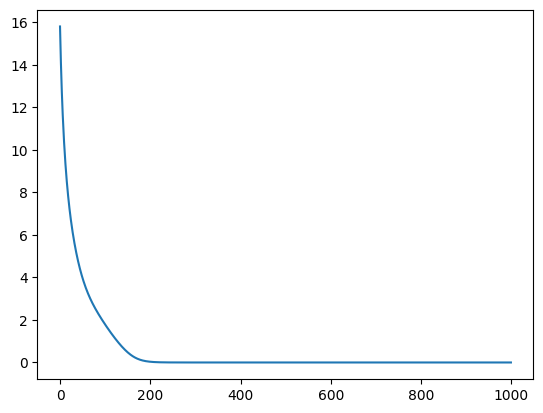

In [119]:
plt.plot(proj_rep_scores)

In [121]:
proj_rep_scores[-1]

-1.3521050259893434e-16j

Still looking good...

## Proj rep and unitarity $B \neq 0$

In [126]:
rdm = get_reduced_density_matrix(cases[2][2], 4, True)
rdm.ireplace_labels(['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)'], ['p','p*'])

<npc.Array shape=(16, 16) labels=['p', 'p*']>

In [128]:
matrix_dim = 2**4

In [129]:
u_a, u_b, u_c = (
    get_random_unitary_operator(rdm, matrix_dim),
    get_random_unitary_operator(rdm, matrix_dim),
    get_random_unitary_operator(rdm, matrix_dim)
)

In [130]:
simple_proj_rep_gradient(u_a, u_b, u_c)

((<npc.Array shape=(16, 16) labels=['p*', 'p']>,
  <npc.Array shape=(16, 16) labels=['p*', 'p']>,
  <npc.Array shape=(16, 16) labels=['p*', 'p']>),
 (30.56834999819379+3.347845294319003e-16j))

In [131]:
proj_rep_scores = list()
unitarity_scores = list()
scores = list()

In [133]:
lr = 0.01

In [134]:
for _ in range(1000):
    ((pr_g_a, pr_g_b, pr_g_c), pr_s) = simple_proj_rep_gradient(u_a, u_b, u_c)
    
    (u_g_a, u_s_a_2, u_s_a_4) = unitarity_gradient(u_a)
    (u_g_b, u_s_b_2, u_s_b_4) = unitarity_gradient(u_b)
    (u_g_c, u_s_c_2, u_s_c_4) = unitarity_gradient(u_c)

    proj_rep_scores.append(pr_s)

    u_score = sum([
        u_s_a_4,
        -2*u_s_a_2,
        u_s_b_4,
        -2*u_s_b_2,
        u_s_c_4,
        -2*u_s_c_2,
        3*matrix_dim
    ])

    unitarity_scores.append(u_score)

    scores.append(lr*(pr_s + u_score/4.0))

    g_a = pr_g_a + u_g_a
    g_b = pr_g_b + u_g_b
    g_c = pr_g_c + u_g_c
    
    u_a -= lr*g_a
    u_b -= lr*g_b
    u_c -= lr*g_c

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


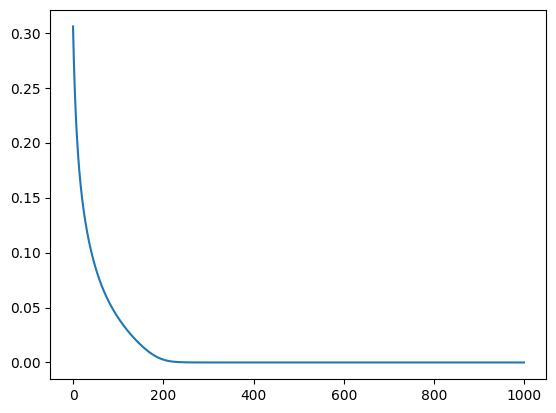

In [135]:
plt.plot(scores)

In [136]:
scores[-1]

2.9401945973393705e-18j

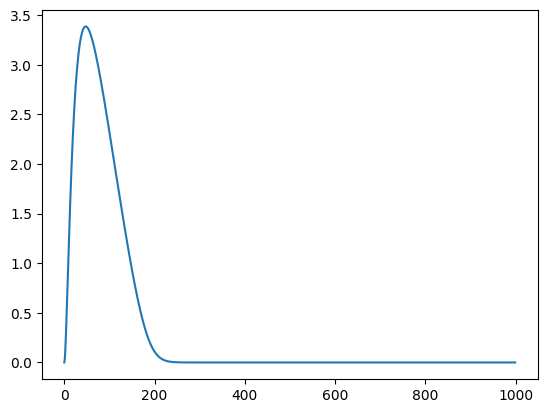

In [137]:
plt.plot(unitarity_scores)

In [138]:
unitarity_scores[-1]

-3.74490055133504e-17j

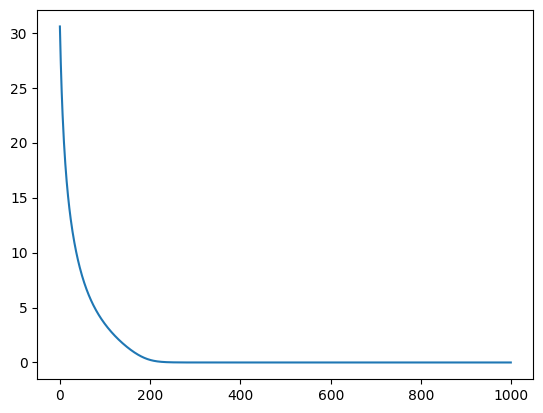

In [139]:
plt.plot(proj_rep_scores)

In [140]:
proj_rep_scores[-1]

3.0338171111227465e-16j

Still looking good...

## Only update one proj rep condition

In [141]:
initial_params = initalize_optimization(
    test_cases, 4, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [142]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [143]:
group_products

[('IX', 'IX', 'II'),
 ('XI', 'XI', 'II'),
 ('XX', 'XX', 'II'),
 ('IX', 'XI', 'XX'),
 ('XI', 'IX', 'XX'),
 ('IX', 'XX', 'XI'),
 ('XX', 'IX', 'XI'),
 ('XX', 'XI', 'IX'),
 ('XI', 'XX', 'IX')]

In [145]:
sub_group_products = [('XI', 'IX', 'XX'),]

In [146]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    sub_group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    1000
)

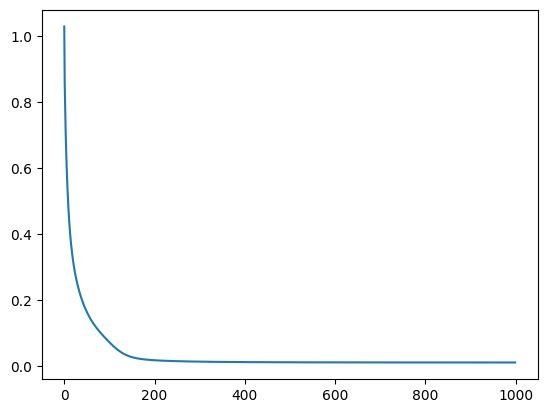

In [147]:
plt.plot(cost_function_scores)

In [148]:
cost_function_scores[-1]

0.010528333886986405

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/111217294.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


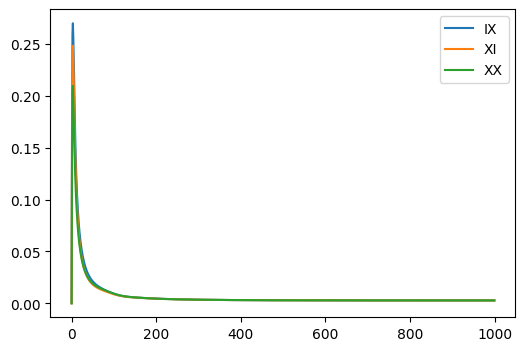

In [149]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in unitarity_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

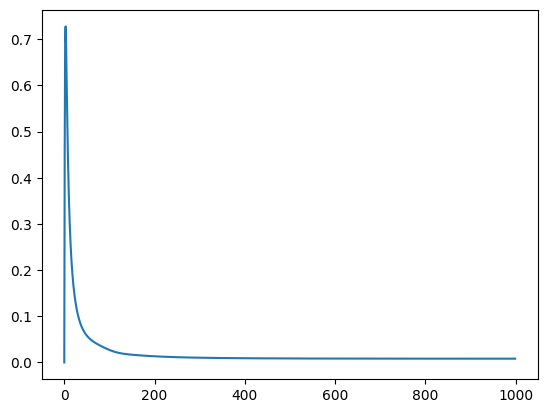

In [150]:
plt.plot(overall_unitarity_scores)

In [151]:
[l[-1] for l in unitarity_scores.values()]

[0.002744716543073622, 0.002744712222980894, 0.002744716841789341]

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/18745376.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


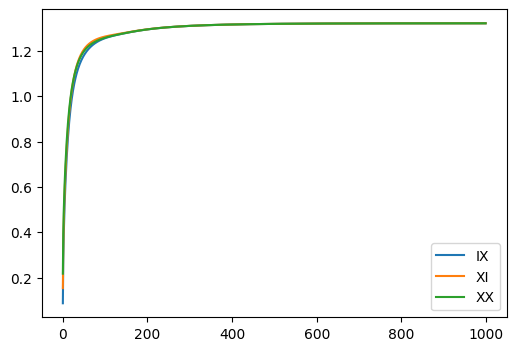

In [152]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in overlap_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

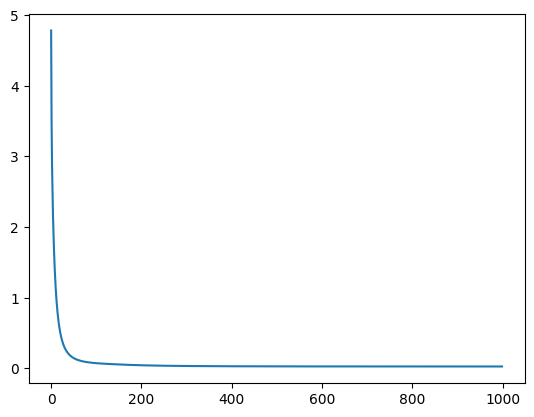

In [153]:
plt.plot(overall_target_overlap_scores)

In [154]:
overall_target_overlap_scores[-1]

0.0259647107971858

In [155]:
[l[-1] for l in overlap_scores.values()]

[1.3211817155154013, 1.3211819054867322, 1.3211818630206171]

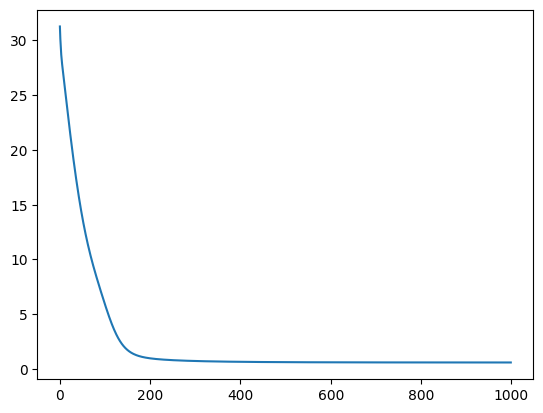

In [156]:
plt.plot(proj_rep_scores)

In [157]:
proj_rep_scores[-1]

0.6016066346820246

Not good...

## Only update one proj rep condition, simplify grad function

Messy, but useful for debugging. Be careful...!

In [158]:
def update_grad_generic_case(unitary_triple, group_label_triple, matrix_mul,
                          grad_dict, scores_dict):
    
    u_a, u_b, u_c = unitary_triple

    grads, score = simple_proj_rep_gradient(u_a, u_b, u_c)

    for l, g in zip(group_label_triple, grads):
        update_grad_dict(grad_dict, l, g)

    scores_dict[group_label_triple] = score

In [173]:
initial_params = initalize_optimization(
    test_cases, 4, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [174]:
reduced_density_matrices

{'IX': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>,
 'XI': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>,
 'XX': <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>}

In [175]:
for l in reduced_density_matrices:
    reduced_density_matrices[l].ireplace_labels(['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)'], ['p','p*'])

In [176]:
for l in solutions_dict:
    solutions_dict[l].ireplace_labels(['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)'], ['p','p*'])

In [177]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [178]:
group_products

[('IX', 'IX', 'II'),
 ('XI', 'XI', 'II'),
 ('XX', 'XX', 'II'),
 ('IX', 'XI', 'XX'),
 ('XI', 'IX', 'XX'),
 ('IX', 'XX', 'XI'),
 ('XX', 'IX', 'XI'),
 ('XX', 'XI', 'IX'),
 ('XI', 'XX', 'IX')]

In [179]:
sub_group_products = [('XI', 'IX', 'XX'),]

In [180]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    'p',
    'p*',
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    sub_group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    1000
)

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


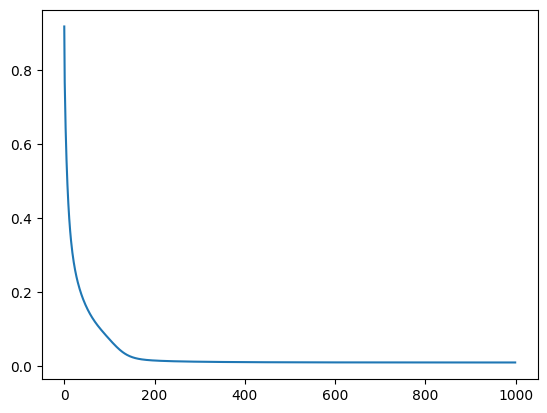

In [181]:
plt.plot(cost_function_scores)

In [182]:
cost_function_scores[-1]

(0.010524805510929755+7.531606567787214e-18j)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/111217294.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


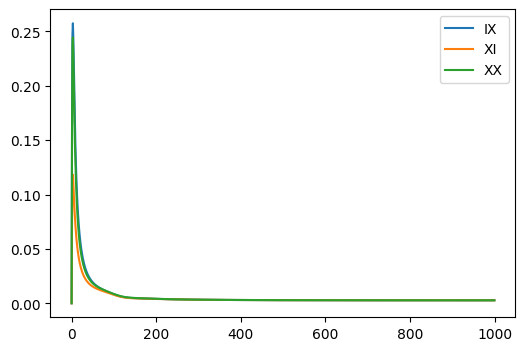

In [183]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in unitarity_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

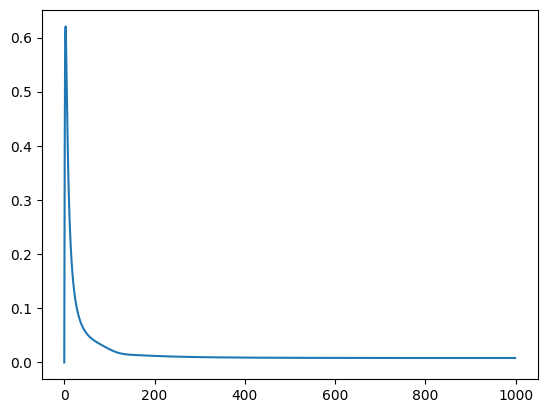

In [184]:
plt.plot(overall_unitarity_scores)

In [185]:
[l[-1] for l in unitarity_scores.values()]

[0.002743716098564164, 0.0027436912669749347, 0.0027437300448625024]

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/18745376.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


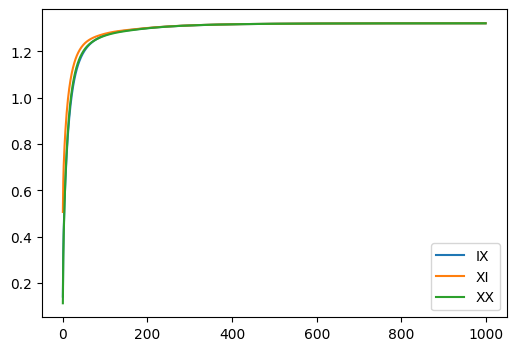

In [186]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in overlap_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

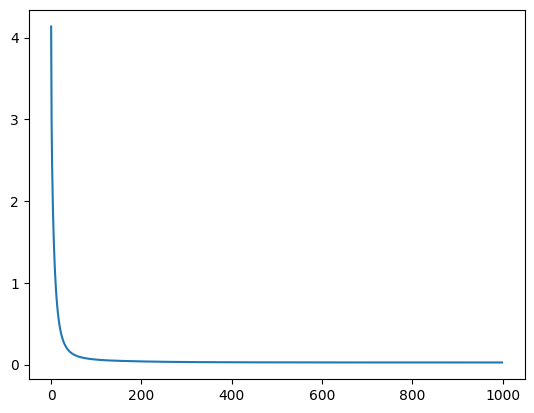

In [187]:
plt.plot(overall_target_overlap_scores)

In [188]:
overall_target_overlap_scores[-1]

0.025955068260841603

In [189]:
[l[-1] for l in overlap_scores.values()]

[1.321198988338311, 1.3211993396698338, 1.321198984736701]

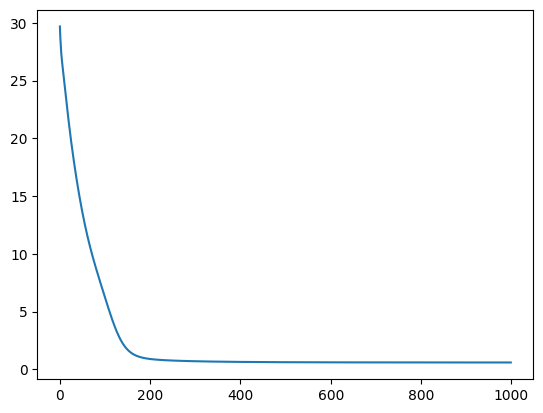

In [190]:
plt.plot(proj_rep_scores)

In [191]:
proj_rep_scores[-1]

(0.6014209966023394+7.531606567787214e-16j)

Didn't change much, so at least we know the function is working...!

## B=0 two site.

There should be only one solution and no room for degeneracy in this case.

In [194]:
initial_params = initalize_optimization(
    test_cases, 2, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [204]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [205]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    300
)

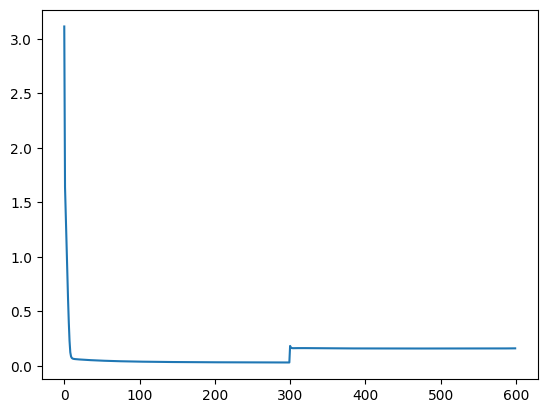

In [206]:
plt.plot(cost_function_scores)

In [207]:
cost_function_scores[-1]

0.16222187122152654

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/111217294.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


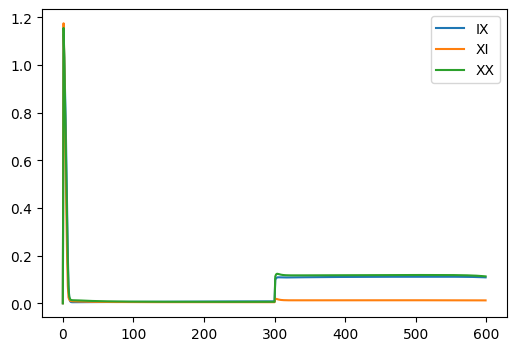

In [208]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in unitarity_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/18745376.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


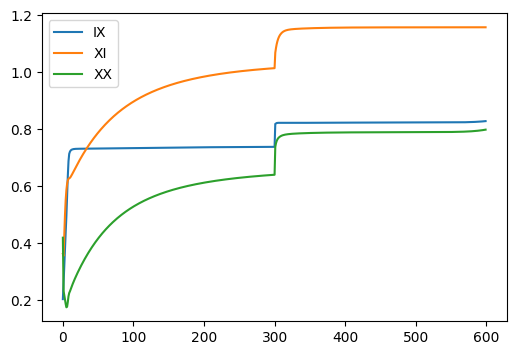

In [209]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in overlap_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

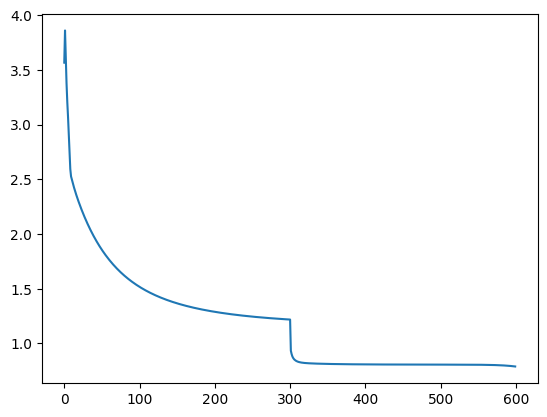

In [210]:
plt.plot(overall_target_overlap_scores)

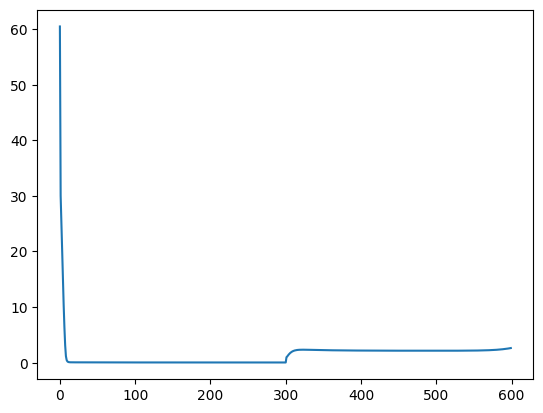

In [211]:
plt.plot(proj_rep_scores)

Jumping behaviour is weird? Definitely not what's expected. Should try with exact solutions.

## B=0 two site, start from exact solution.

In [212]:
np_X

array([[0, 1],
       [1, 0]])

In [214]:
np_Z

array([[ 1,  0],
       [ 0, -1]])

In [215]:
np_Y

array([[ 0.+0.j, -0.-1.j],
       [ 0.+1.j,  0.+0.j]])

### Build exact solutions

In [324]:
tp_X = npc.Array.from_ndarray_trivial(np_X, labels=['p', 'p*'])

In [325]:
tp_Z = npc.Array.from_ndarray_trivial(np_Z, labels=['p', 'p*'])

In [326]:
tp_I = npc.Array.from_ndarray_trivial(np_I, labels=['p', 'p*'])

In [327]:
tp_Y = 1j*multiply_tenpy_matrices(tp_Z, tp_X)

In [328]:
XI_sol = npc.outer(
    tp_X.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_Z.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

XI_sol = XI_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

In [329]:
IX_sol = npc.outer(
    tp_Z.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_I.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

IX_sol = IX_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

In [330]:
XX_sol = npc.outer(
    tp_Y.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_Z.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

XX_sol = XX_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

In [331]:
test_cases = cases[0]

initial_params = initalize_optimization(
    test_cases[1:], 2, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [332]:
solutions_dict = {
    'IX': IX_sol,
    'XI': XI_sol,
    'XX': XX_sol
}

In [333]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [334]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    50
)

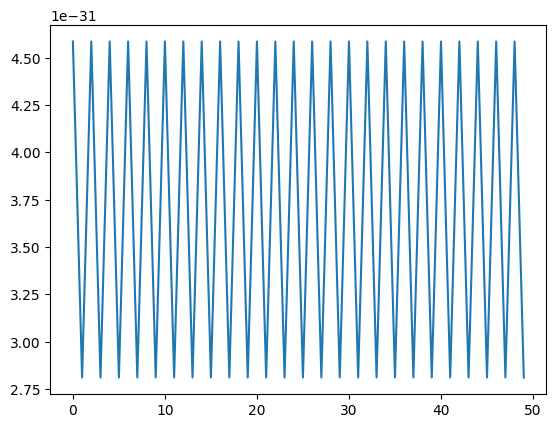

In [336]:
plt.plot(cost_function_scores)

In [337]:
cost_function_scores[1]

2.8103169748498546e-31

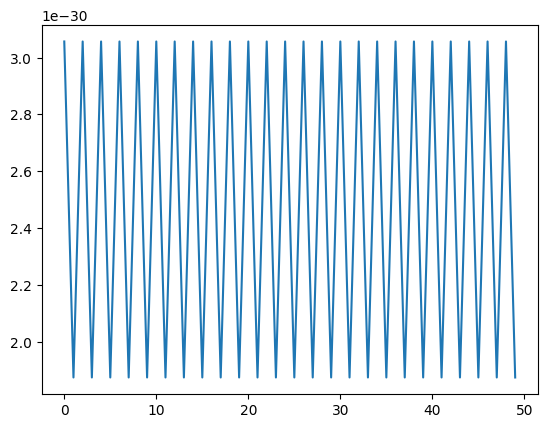

In [338]:
plt.plot(overall_target_overlap_scores)

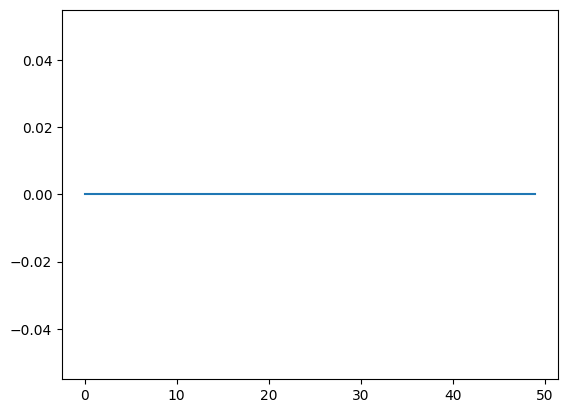

In [339]:
plt.plot(proj_rep_scores)

In [340]:
proj_rep_scores[-1]

0.0

In [341]:
unitarity_scores['IX'][-1]

0.0

In [342]:
unitarity_scores['XI'][-1]

0.0

In [343]:
unitarity_scores['XX'][-1]

0.0

In [344]:
overlap_scores['IX'][-1]

1.4142135623730958

In [345]:
overlap_scores['XI'][-1]

1.4142135623730958

In [346]:
overlap_scores['XX'][-1]

1.4142135623730958

## Add noise to exact solution

In [394]:
def get_solution_noise():
    X = np.random.rand(4, 4) + 1j*np.random.rand(4, 4)

    a = npc.Array.from_ndarray_trivial(X, labels=['(p0.p1)', '(p0*.p1*)'])

    return a

In [398]:
noise_scaling = 0.01

In [399]:
XI_sol = npc.outer(
    tp_X.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_Z.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

XI_sol = XI_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

XI_sol += noise_scaling*get_solution_noise()

In [400]:
IX_sol = npc.outer(
    tp_Z.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_I.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

IX_sol = IX_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

IX_sol += noise_scaling*get_solution_noise()

In [401]:
XX_sol = npc.outer(
    tp_Y.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_Z.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

XX_sol = XX_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

XX_sol += noise_scaling*get_solution_noise()

In [402]:
test_cases = cases[0]

initial_params = initalize_optimization(
    test_cases[1:], 2, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [403]:
solutions_dict = {
    'IX': IX_sol,
    'XI': XI_sol,
    'XX': XX_sol
}

In [404]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [405]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    50
)

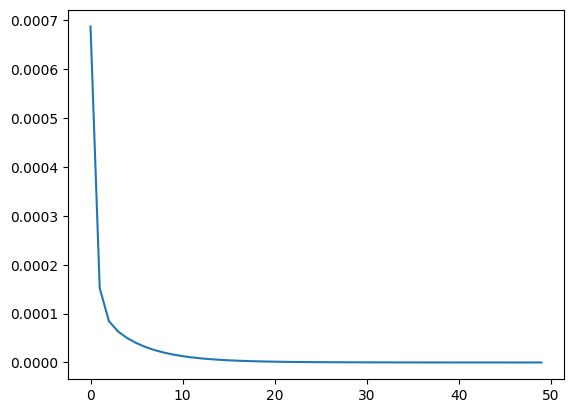

In [406]:
plt.plot(cost_function_scores)

In [407]:
cost_function_scores[1]

0.00015195069605505846

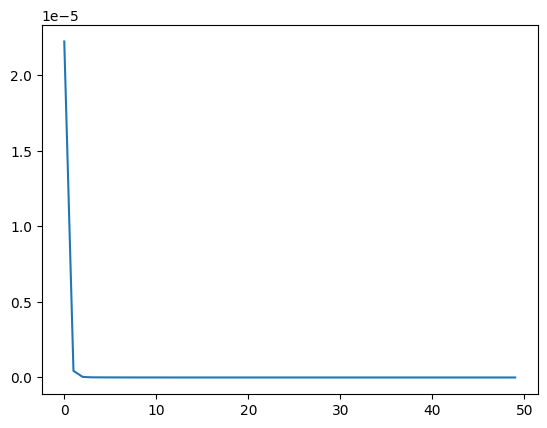

In [408]:
plt.plot(overall_target_overlap_scores)

In [410]:
overall_target_overlap_scores[-1]

9.919855722025484e-10

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/18745376.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


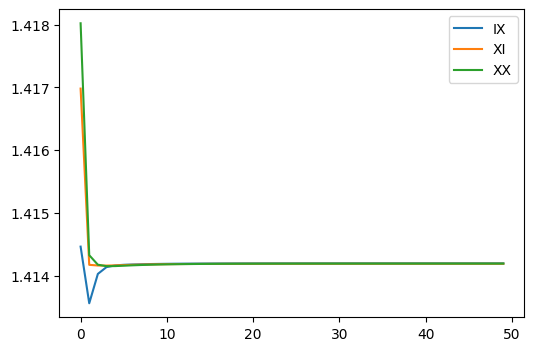

In [413]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in overlap_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

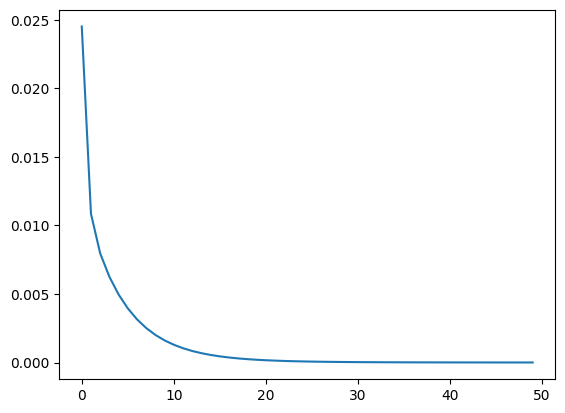

In [411]:
plt.plot(proj_rep_scores)

In [412]:
proj_rep_scores[-1]

1.8439309341644616e-06

### Increase noise

In [414]:
noise_scaling = 0.1

In [415]:
XI_sol = npc.outer(
    tp_X.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_Z.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

XI_sol = XI_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

XI_sol += noise_scaling*get_solution_noise()

In [416]:
IX_sol = npc.outer(
    tp_Z.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_I.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

IX_sol = IX_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

IX_sol += noise_scaling*get_solution_noise()

In [417]:
XX_sol = npc.outer(
    tp_Y.replace_labels(['p', 'p*'], ['p0', 'p0*']),
    tp_Z.replace_labels(['p', 'p*'], ['p1', 'p1*'])
)

XX_sol = XX_sol.combine_legs([['p0', 'p1'], ['p0*', 'p1*']])

XX_sol += noise_scaling*get_solution_noise()

In [418]:
test_cases = cases[0]

initial_params = initalize_optimization(
    test_cases[1:], 2, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [419]:
solutions_dict = {
    'IX': IX_sol,
    'XI': XI_sol,
    'XX': XX_sol
}

In [420]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [421]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    50
)

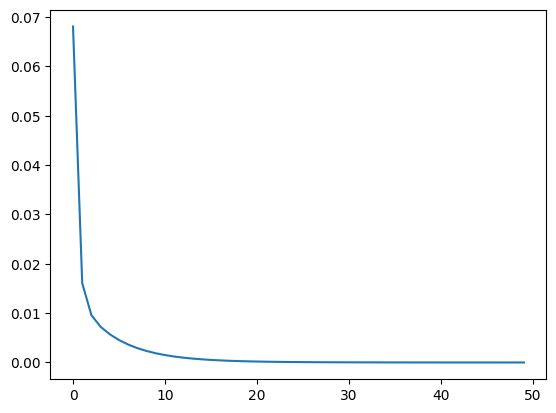

In [422]:
plt.plot(cost_function_scores)

In [423]:
cost_function_scores[1]

0.0160575017101484

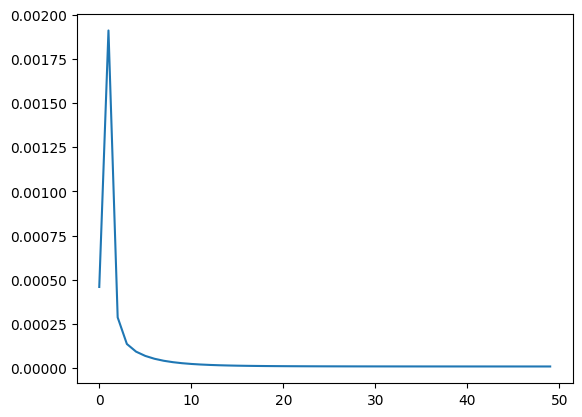

In [424]:
plt.plot(overall_target_overlap_scores)

In [425]:
overall_target_overlap_scores[-1]

9.395102405252845e-06

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_2365/18745376.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


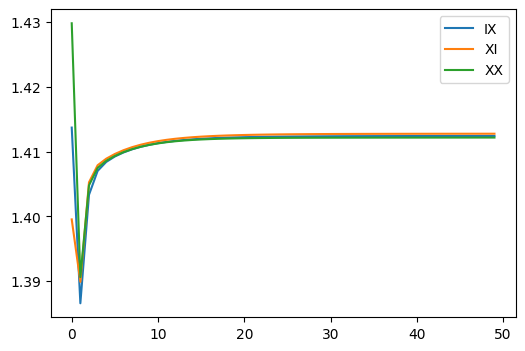

In [426]:
fig, ax = plt.subplots(figsize=(6,4))

for l, X in overlap_scores.items():
    ax.plot(X, label=l)

ax.legend()

fig.show()

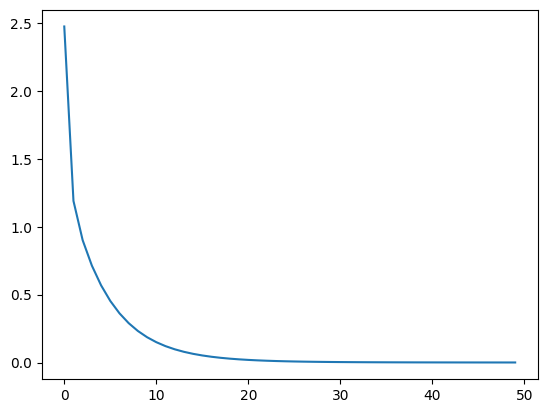

In [427]:
plt.plot(proj_rep_scores)

In [428]:
proj_rep_scores[-1]

0.00021706978739466365

In [430]:
overall_unitarity_scores

[0.5767931212341555,
 0.05161517782409586,
 0.0071785064528242515,
 0.0009630891020862009,
 0.00014262739012860237,
 2.9516796471451556e-05,
 1.0420113915721174e-05,
 5.542516557710542e-06,
 3.6430214978011577e-06,
 2.7416362815557704e-06,
 2.306596489809465e-06,
 2.1182630280947023e-06,
 2.062640689359796e-06,
 2.075863033468295e-06,
 2.1216899144249624e-06,
 2.179873029639623e-06,
 2.239512887136641e-06,
 2.295135834273765e-06,
 2.344358784434064e-06,
 2.3865037652726073e-06,
 2.4217844512008924e-06,
 2.450836647405197e-06,
 2.474454477763288e-06,
 2.4934482496519195e-06,
 2.5085732495711e-06,
 2.5204990556915163e-06,
 2.529801088613226e-06,
 2.5369638372296777e-06,
 2.542389516690946e-06,
 2.546408746084694e-06,
 2.5492913984237475e-06,
 2.551256638838595e-06,
 2.552481840112364e-06,
 2.553110182823559e-06,
 2.553257056447933e-06,
 2.553015388429003e-06,
 2.5524599553961025e-06,
 2.551650937654415e-06,
 2.5506367888894488e-06,
 2.549456532108252e-06,
 2.548141624814093e-06,
 2.54671

## B=0, two site, random initialization

In [431]:
test_cases = cases[0]

initial_params = initalize_optimization(
    test_cases[1:], 2, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [432]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [433]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    300
)

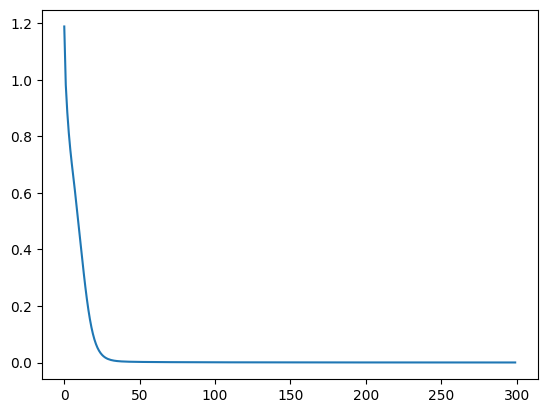

In [434]:
plt.plot(cost_function_scores)

In [448]:
cost_function_scores[-1]

0.0001120357224846431

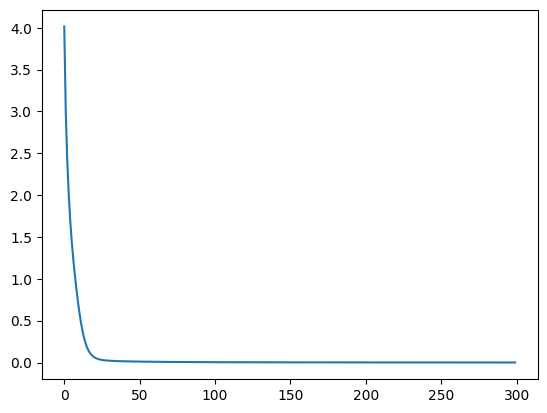

In [437]:
plt.plot(overall_target_overlap_scores)

In [439]:
overall_target_overlap_scores[-1]

0.0006075573925538006

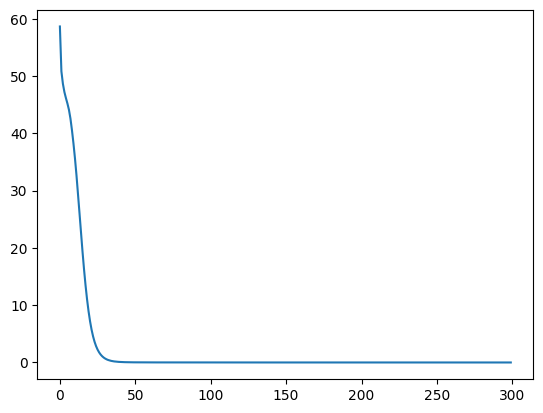

In [440]:
plt.plot(proj_rep_scores)

In [441]:
proj_rep_scores[-1]

0.0008673867526587387

In [442]:
unitarity_scores['IX'][-1]

2.1946077980672385e-05

In [443]:
unitarity_scores['XI'][-1]

8.39391148419466e-05

In [444]:
unitarity_scores['XX'][-1]

5.715808817718937e-05

In [445]:
overlap_scores['IX'][-1]

1.4040408753940306

In [446]:
overlap_scores['XI'][-1]

1.3971465599152586

In [447]:
overlap_scores['XX'][-1]

1.3996261959458112

## B=0, five site, random initialization, small pr learning rate

In [467]:
test_cases = cases[0]

initial_params = initalize_optimization(
    test_cases[1:], 5, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [468]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.001

In [469]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    1000
)

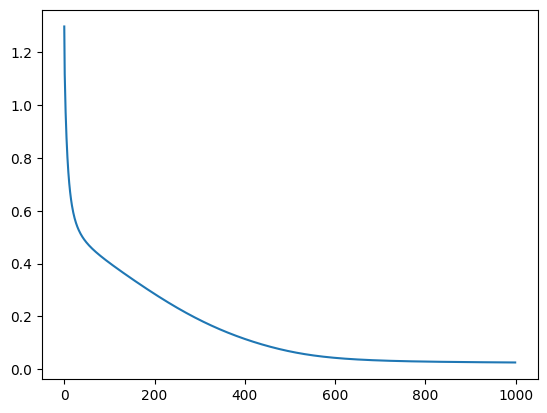

In [470]:
plt.plot(cost_function_scores)

In [471]:
cost_function_scores[-1]

0.025681450954753982

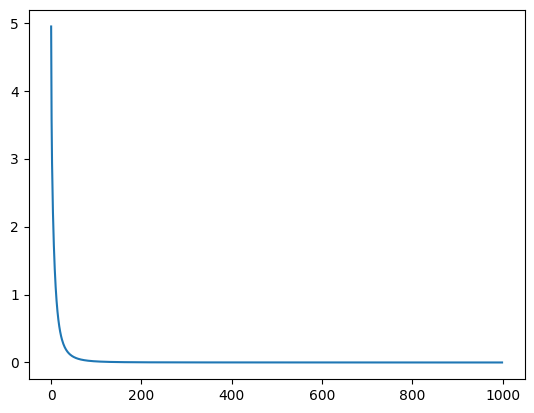

In [472]:
plt.plot(overall_target_overlap_scores)

In [473]:
overall_target_overlap_scores[-1]

0.00020646095986299887

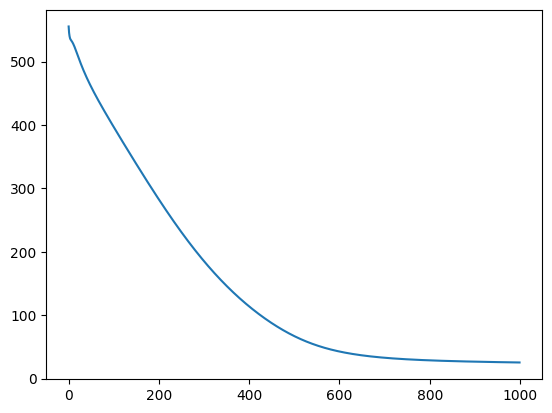

In [474]:
plt.plot(proj_rep_scores)

In [475]:
proj_rep_scores[-1]

25.458565355288844

In [476]:
unitarity_scores['IX'][-1]

0.0007663320884674363

In [477]:
unitarity_scores['XI'][-1]

0.0010502467531310344

In [478]:
unitarity_scores['XX'][-1]

0.0007423072315440038

In [479]:
overlap_scores['IX'][-1]

1.4058946085626067

In [480]:
overlap_scores['XI'][-1]

1.4059111557763089

In [481]:
overlap_scores['XX'][-1]

1.4059476073730042

## B=0, five site, random initialization, equal pr learning rate

In [485]:
test_cases = cases[0]

initial_params = initalize_optimization(
    test_cases[1:], 5, random_initialisation=True
)

(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores
) = initial_params

In [486]:
unitarity_lr = 0.1
overlap_lr = 0.1
proj_rep_lr = 0.1

In [487]:
repeat_update(
    reduced_density_matrices,
    overlap_targets,
    leg_label,
    leg_conj_label,
    matrix_dim,
    solutions_dict,
    unitarity_scores,
    overall_unitarity_scores,
    overlap_scores,
    overall_target_overlap_scores,
    proj_rep_scores,
    cost_function_scores,
    group_products,
    unitarity_lr,
    overlap_lr,
    proj_rep_lr,
    1000
)

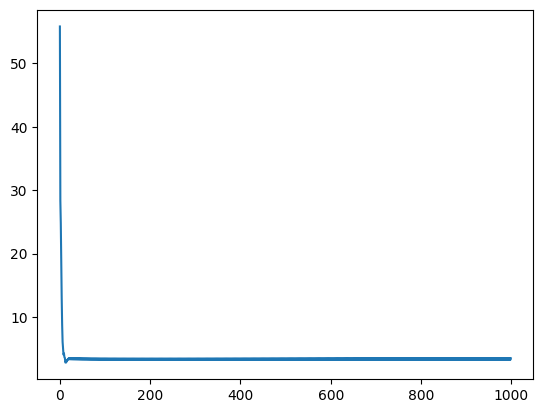

In [488]:
plt.plot(cost_function_scores)

In [489]:
cost_function_scores[-1]

3.4998581293060433

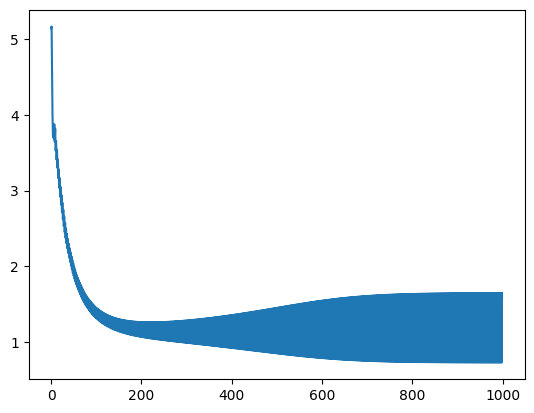

In [490]:
plt.plot(overall_target_overlap_scores)

In [491]:
overall_target_overlap_scores[-1]

1.6463327726159713

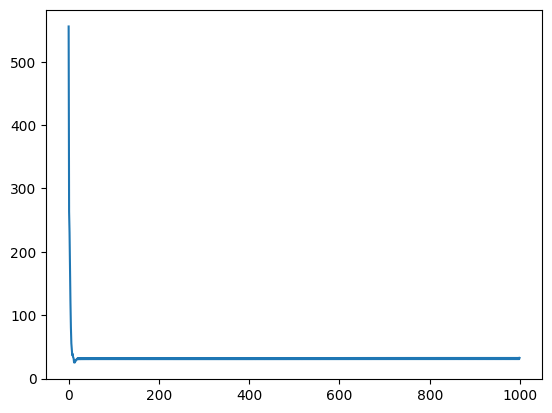

In [492]:
plt.plot(proj_rep_scores)

In [493]:
proj_rep_scores[-1]

32.55463949489035

In [494]:
unitarity_scores['IX'][-1]

2.1610336782268007

In [495]:
unitarity_scores['XI'][-1]

2.1610339443683344

In [496]:
unitarity_scores['XX'][-1]

2.1610340248532296

In [497]:
overlap_scores['IX'][-1]

0.6734134540192441

In [498]:
overlap_scores['XI'][-1]

0.6734222022032894

In [499]:
overlap_scores['XX'][-1]

0.6734193043117513

Very bad!

## B=0, foure site, random initialization sweep

In [506]:
sweep_overall_unitarity_scores = list()
sweep_overall_overlap_scores = list()
sweep_proj_rep_scores = list()
sweep_cost_function_scores = list()

In [507]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.01

In [508]:
test_cases = cases[0]

for i in range(100):
    if i % 10 == 0:
        print(i)

    initial_params = initalize_optimization(
        test_cases[1:], 4, random_initialisation=True
    )
    
    (
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores
    ) = initial_params

    repeat_update(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores,
        group_products,
        unitarity_lr,
        overlap_lr,
        proj_rep_lr,
        70
    )

    sweep_overall_unitarity_scores.append(overall_unitarity_scores[-1])
    sweep_overall_overlap_scores.append(overall_target_overlap_scores[-1])
    sweep_proj_rep_scores.append(proj_rep_scores[-1])
    sweep_cost_function_scores.append(cost_function_scores[-1])

0
10
20
30
40
50
60
70
80
90


In [509]:
pd.Series(sweep_cost_function_scores).describe()

count    100.000000
mean       0.373929
std        0.194510
min        0.010918
25%        0.250626
50%        0.317682
75%        0.495559
max        0.951363
dtype: float64

In [513]:
pd.Series(sweep_overall_overlap_scores).describe()

count    100.000000
mean       0.151559
std        0.175184
min        0.014219
25%        0.031693
50%        0.049024
75%        0.271369
max        0.794419
dtype: float64

In [514]:
pd.Series(sweep_proj_rep_scores).describe()

count    100.000000
mean      33.766116
std       18.534956
min        0.572589
25%       22.967685
50%       28.363711
75%       45.429294
max       88.082774
dtype: float64

In [515]:
pd.Series(sweep_overall_unitarity_scores).describe()

count    100.000000
mean       0.180457
std        0.085570
min        0.007645
25%        0.127287
50%        0.176229
75%        0.219108
max        0.427658
dtype: float64

In [517]:
i_min = np.argmin(np.array(sweep_cost_function_scores))

In [518]:
(
    sweep_cost_function_scores[i_min],
    sweep_overall_unitarity_scores[i_min],
    sweep_overall_overlap_scores[i_min],
    sweep_proj_rep_scores[i_min]
)

(0.010917623984818232,
 0.007645220884381132,
 0.03078894359847425,
 0.5725890878718509)

## B=0, four site, random initialization sweep, larger pr learning rate

In [519]:
sweep_overall_unitarity_scores = list()
sweep_overall_overlap_scores = list()
sweep_proj_rep_scores = list()
sweep_cost_function_scores = list()

In [520]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

In [521]:
test_cases = cases[0]

for i in range(200):
    if i % 10 == 0:
        print(i)

    initial_params = initalize_optimization(
        test_cases[1:], 4, random_initialisation=True
    )
    
    (
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores
    ) = initial_params

    repeat_update(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores,
        group_products,
        unitarity_lr,
        overlap_lr,
        proj_rep_lr,
        70
    )

    sweep_overall_unitarity_scores.append(overall_unitarity_scores[-1])
    sweep_overall_overlap_scores.append(overall_target_overlap_scores[-1])
    sweep_proj_rep_scores.append(proj_rep_scores[-1])
    sweep_cost_function_scores.append(cost_function_scores[-1])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [522]:
pd.Series(sweep_cost_function_scores).describe()

count    200.000000
mean       0.181645
std        0.250288
min        0.005727
25%        0.012677
50%        0.167159
75%        0.172939
max        2.582134
dtype: float64

In [523]:
pd.Series(sweep_overall_overlap_scores).describe()

count    200.000000
mean       0.723918
std        0.619202
min        0.033602
25%        0.066932
50%        0.871497
75%        0.897473
max        1.952117
dtype: float64

In [524]:
pd.Series(sweep_proj_rep_scores).describe()

count    200.000000
mean       1.327396
std        4.532690
min        0.010614
25%        0.022961
50%        0.617915
75%        0.644639
max       50.671855
dtype: float64

In [525]:
pd.Series(sweep_overall_unitarity_scores).describe()

count    200.000000
mean       0.089167
std        0.133621
min        0.002076
25%        0.004657
50%        0.067630
75%        0.069943
max        0.902328
dtype: float64

In [526]:
i_min = np.argmin(np.array(sweep_cost_function_scores))

In [527]:
(
    sweep_cost_function_scores[i_min],
    sweep_overall_unitarity_scores[i_min],
    sweep_overall_overlap_scores[i_min],
    sweep_proj_rep_scores[i_min]
)

(0.005726783700343725,
 0.002076482656981682,
 0.03360229503529089,
 0.010614064915529298)

That's quite good!

## B=0.3, 6 site, random initialization sweep, larger pr learning rate

In [528]:
sweep_overall_unitarity_scores = list()
sweep_overall_overlap_scores = list()
sweep_proj_rep_scores = list()
sweep_cost_function_scores = list()

In [529]:
unitarity_lr = 0.3
overlap_lr = 0.3
proj_rep_lr = 0.05

In [530]:
test_cases = cases[3]

for i in range(200):
    if i % 10 == 0:
        print(i)

    initial_params = initalize_optimization(
        test_cases[1:], 6, random_initialisation=True
    )
    
    (
            reduced_density_matrices,
            overlap_targets,
            leg_label,
            leg_conj_label,
            matrix_dim,
            solutions_dict,
            unitarity_scores,
            overall_unitarity_scores,
            overlap_scores,
            overall_target_overlap_scores,
            proj_rep_scores,
            cost_function_scores
    ) = initial_params

    repeat_update(
        reduced_density_matrices,
        overlap_targets,
        leg_label,
        leg_conj_label,
        matrix_dim,
        solutions_dict,
        unitarity_scores,
        overall_unitarity_scores,
        overlap_scores,
        overall_target_overlap_scores,
        proj_rep_scores,
        cost_function_scores,
        group_products,
        unitarity_lr,
        overlap_lr,
        proj_rep_lr,
        70
    )

    sweep_overall_unitarity_scores.append(overall_unitarity_scores[-1])
    sweep_overall_overlap_scores.append(overall_target_overlap_scores[-1])
    sweep_proj_rep_scores.append(proj_rep_scores[-1])
    sweep_cost_function_scores.append(cost_function_scores[-1])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [531]:
pd.Series(sweep_cost_function_scores).describe()

count    200.000000
mean       0.169854
std        0.220169
min        0.008465
25%        0.013182
50%        0.162433
75%        0.165094
max        1.228192
dtype: float64

In [532]:
pd.Series(sweep_overall_overlap_scores).describe()

count    200.000000
mean       0.682293
std        0.591422
min        0.049730
25%        0.076506
50%        0.851033
75%        0.864390
max        1.900471
dtype: float64

In [533]:
pd.Series(sweep_proj_rep_scores).describe()

count    200.000000
mean       1.215481
std        3.446184
min        0.015611
25%        0.023936
50%        0.592998
75%        0.602350
max       17.802483
dtype: float64

In [534]:
pd.Series(sweep_overall_unitarity_scores).describe()

count    200.000000
mean       0.089807
std        0.154308
min        0.002998
25%        0.004767
50%        0.066447
75%        0.067575
max        0.843871
dtype: float64

In [535]:
i_min = np.argmin(np.array(sweep_cost_function_scores))

In [536]:
(
    sweep_cost_function_scores[i_min],
    sweep_overall_unitarity_scores[i_min],
    sweep_overall_overlap_scores[i_min],
    sweep_proj_rep_scores[i_min]
)

(0.008464869109648127,
 0.0029981689992126803,
 0.049729679747975264,
 0.015611089450217719)

That's quite good!

# Conclusions
* Seems to be converging, needs more testing.
* Random initialization over many points seems quite important. The "loss landscape" appears to be quite bumpy.
* The hyperparameters need to be set independently. A lower proj rep learning rate is important, otherwise dominates.
* There is scope for additional gradient descent schemes, don't just have to do it naively. Momentum, rms etc. 